# Agentic RAG as Research Assistant
Based on several papers but with google search as tools to search information when necessary

[Build a Retrieval Augmented Generation (RAG) App: Part 2 | 🦜️🔗 LangChain](https://python.langchain.com/docs/tutorials/qa_chat_history/)

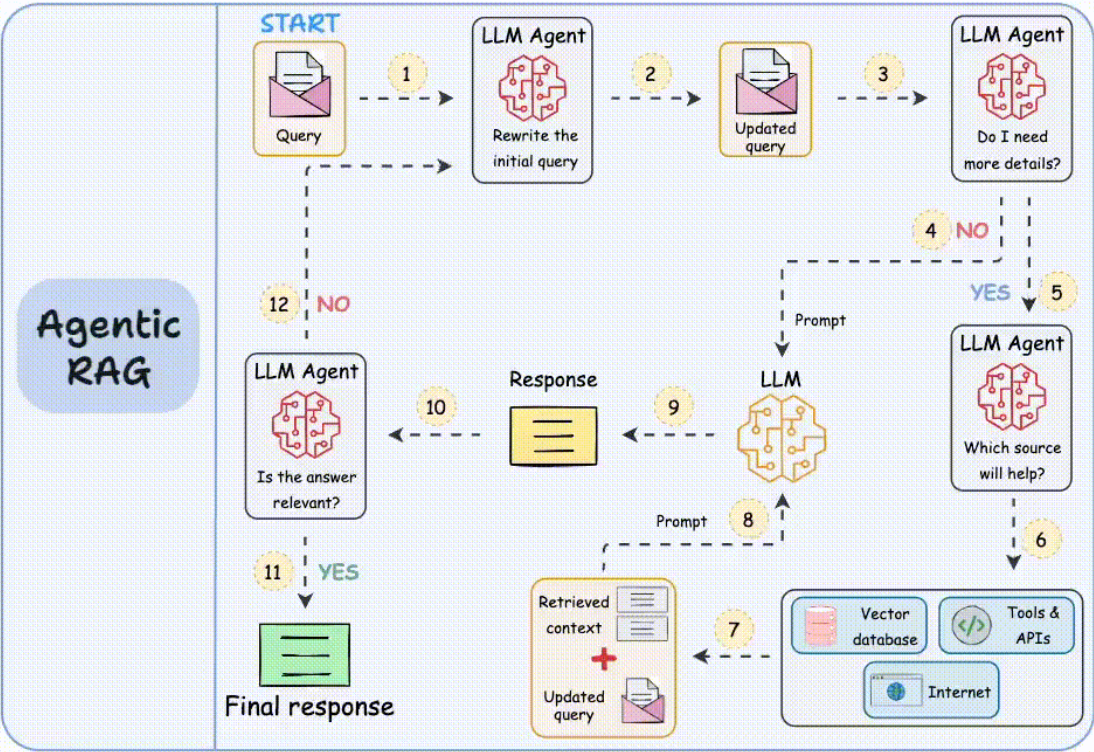

In [1]:
%load_ext autoreload
%autoreload 2

## Test LangChain

In [2]:
# libraries
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import ChatOpenAI
from langchain_core.messages import (
    AnyMessage,
    SystemMessage,
    HumanMessage,
    ToolMessage,
    AIMessage,
)

model = ChatOpenAI(model="gpt-3.5-turbo")
message = [
    SystemMessage(content="Translate the following from English to German"),
    HumanMessage("Hello world!"),
]

result = model.invoke(message)

print(result)

Enter API key for OpenAI:  ········


content='Hallo Welt!' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 21, 'total_tokens': 25, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-1e3d1046-c258-42da-b835-c37451dbe412-0' usage_metadata={'input_tokens': 21, 'output_tokens': 4, 'total_tokens': 25, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


## Test Google Scholar tool

In [3]:
%pip install --upgrade --quiet google-search-results langchain-community

Note: you may need to restart the kernel to use updated packages.


In [4]:
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_openai import OpenAI
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType

import os

if not os.environ.get("SERPER_API_KEY"):
  os.environ["SERPER_API_KEY"] = getpass.getpass("Enter API key for SERPER_API_KEY: ")


llm = OpenAI(temperature=0)
search = GoogleSerperAPIWrapper()
tools = [
    Tool(
        name="Intermediate Answer",
        func=search.run,
        description="useful for when you need to ask with search",
    )
]

self_ask_with_search = initialize_agent(
    tools, llm, agent=AgentType.SELF_ASK_WITH_SEARCH, verbose=True
)
self_ask_with_search.run(
    "What is the hometown of the reigning men's U.S. Open champion?"
)

Enter API key for SERPER_API_KEY:  ········


C:\Users\wkx61\AppData\Local\Temp\ipykernel_578744\1387032206.py:22: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  self_ask_with_search = initialize_agent(
C:\Users\wkx61\AppData\Local\Temp\ipykernel_578744\1387032206.py:25: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  self_ask_with_search.run(




> Entering new AgentExecutor chain...
 Yes.
Follow up: Who is the reigning men's U.S. Open champion?
Intermediate answer: US Open (tennis) Prize money US$75,000,000 (2024) Men's  Draw S (128 Q ) / 64 D (16 Q ) Current champions Jannik Sinner (singles) Max Purcell Jordan Thompson (doubles) Most singles titles 7 Bill Tilden
Follow up: Where is Jannik Sinner from?
Intermediate answer: San Candido, Italy
So the final answer is: San Candido, Italy

> Finished chain.


'San Candido, Italy'

## Make tools

### Google search tool

In [5]:
from langchain_core.tools import tool


@tool(response_format="content")
def google_search(query: str) -> str:
    """Search Google for the given query."""
    search = GoogleSerperAPIWrapper()
    return search.run(query)

### VectorStore retrieve tool

In [6]:
from pathlib import Path
from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

pdf_path = Path("pdfs")
pdf_files = [f for f in pdf_path.iterdir() if f.suffix == ".pdf"]

print(f"Found {len(pdf_files)} PDF files.")


docs = []

for pdf in pdf_files:
    loader = PyPDFLoader(str(pdf))
    docs.extend(loader.load())

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

from langchain_chroma import Chroma

persist_directory = Path("chroma_db")
if not persist_directory.exists():
    persist_directory.mkdir()

    vector_store = Chroma.from_documents(
        splits, embeddings, persist_directory=str(persist_directory)
    )
else:
    vector_store = Chroma(
        embedding_function=embeddings, persist_directory=str(persist_directory)
    )

Found 3 PDF files.


Ignoring wrong pointing object 501 0 (offset 0)
Ignoring wrong pointing object 503 0 (offset 0)
Ignoring wrong pointing object 529 0 (offset 0)
Ignoring wrong pointing object 572 0 (offset 0)
Ignoring wrong pointing object 577 0 (offset 0)
Ignoring wrong pointing object 945 0 (offset 0)
Ignoring wrong pointing object 949 0 (offset 0)


In [7]:
@tool(response_format="content_and_artifact")
def retrieve_from_vectorstore(query: str):
    """Retrieve documents from the vectorstore."""
    retrieved_docs = vector_store.similarity_search(query, k=3)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata['source']}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

# Setup LangGraph

some references: [Agentic RAG](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/#nodes-and-edges)

In [8]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState, StateGraph, END, START
from typing import TypedDict, Literal

## Simpler Version (No google search no judge)

In [9]:
class RAGState(TypedDict):
    messages: list[AnyMessage]  # adapt to MessagesState
    original_query: str
    current_query: str
    retrieval_results: list[str]
    answer: str

In [10]:
from langchain.prompts import ChatPromptTemplate

rewrite_prompt = ChatPromptTemplate(
    [
        (
            "system",
            """You are a helpful research assistant that rewrites queries to fit the research purpose.\n \
               The new query should based on the previous retrieval results and answers.\
               If it is first iteration, simply optimize the query.""",
        ),
        (
            "human",
            """Here is the initial question: {original_query}, \n \
               Here are the previous retrieval results: {retrieval_results}, \n \
               Here is the previous answer: {answer}, \n \
               Formulate an improved question:""",
        ),
    ]
)

answer_prompt = ChatPromptTemplate(
    [
        (
            "system",
            "You are a RAG agent. Use the retrieved context to answer the query comprehensively",
        ),
        (
            "human",
            """Here is the query: {current_query}\
                Here are the retrieval results: {retrieval_results}\
                Answer the query based on the retrieval results:""",
        ),
    ]
)

### Test without graph


In [11]:
original_query = "What is PILCO?"
state = RAGState(
    messages="",
    original_query=original_query,
    current_query="",
    retrieval_results=[],
    answer="",
)

msg = rewrite_prompt.invoke(
    {
        "original_query": state["original_query"],
        "retrieval_results": [],
        "answer": [],
    }
)
llm = ChatOpenAI(model="gpt-3.5-turbo")
response = llm.invoke(msg)

state["current_query"] = response.content

In [12]:
llm = ChatOpenAI(model="gpt-3.5-turbo")
llm_with_tools = llm.bind_tools(
    [retrieve_from_vectorstore],
    tool_choice="retrieve_from_vectorstore",
)
response2 = llm_with_tools.invoke(state["current_query"])
state["messages"] = [response2]

In [13]:
response2.tool_calls

[{'name': 'retrieve_from_vectorstore',
  'args': {'query': 'Probabilistic Inference for Learning Control (PILCO) algorithm'},
  'id': 'call_Yxe8GmOWkZnzW2PxYISkgYiO',
  'type': 'tool_call'}]

In [14]:
tool_node = ToolNode([retrieve_from_vectorstore])
response3 = tool_node.invoke(state)

In [15]:
response3["messages"][-1].content

'Source: pdfs\\Kober et al. - 2013 - Reinforcement learning in robotics A survey.pdf\nContent: uncertainty and using it in the inner-loop of a policy searchmethod enabled eﬀective\nﬂight control using only minutes of collected data, while performance was compromised\nby considering a best-ﬁt model. This approach uses explicitMonte-Carlo simulation in\nthe sample estimates.\nBy treating model uncertainty as if it were noise (Schneider,1996) as well as em-\nploying analytic approximations of forward simulation, a cart-pole task can be solved\nwith less than 20 seconds of interaction with the physical system (Deisenroth and Ras-\nmussen, 2011); a visually driven block-stacking task has also been learned data-eﬃciently\n(Deisenroth et al., 2011). Similarly, solving a linearizedcontrol problem with multiple\nprobabilistic models and combining the resulting closed-loop control with open-loop con-\ntrol has resulted in autonomous sideways sliding into a parking spot (Kolter et al., 2010).\nIn

In [16]:
state["retrieval_results"] = response3["messages"][-1].content
llm = ChatOpenAI(model="gpt-3.5-turbo")
msg = answer_prompt.invoke(
    {
        "current_query": state["current_query"],
        "retrieval_results": state["retrieval_results"],
    }
)
response4 = llm.invoke(msg)

In [17]:
print(response4.content)

The Probabilistic Inference for Learning Control (PILCO) algorithm is an approach that utilizes probabilistic models and inference techniques in the context of reinforcement learning. PILCO focuses on incorporating uncertainty into the learning process to make more informed decisions while interacting with the environment.

Based on the retrieved content, PILCO leverages model uncertainty by treating it as noise and employs techniques like explicit Monte-Carlo simulation and analytic approximations of forward simulation. This approach allows PILCO to effectively control systems with minimal data collection time. For example, tasks like solving a cart-pole task, a visually driven block-stacking task, and even autonomous sideways sliding into a parking spot have been successfully accomplished using PILCO with only a short interaction time with the physical system.

Instead of explicitly learning a model of the system dynamics, PILCO directly learns from the data and incorporates probabil

### Build the graph

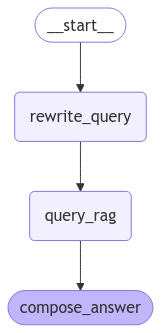

In [18]:
rewrite_prompt = ChatPromptTemplate(
    [
        (
            "system",
            """You are a helpful research assistant that rewrites queries to fit the research purpose.\n \
               The new query should based on the previous retrieval results and answers.\
               If it is first iteration, simply optimize the query.""",
        ),
        (
            "human",
            """Here is the initial question: {original_query}, \n \
               Here are the previous retrieval results: {retrieval_results}, \n \
               Here is the previous answer: {answer}, \n \
               Formulate an improved question:""",
        ),
    ]
)

answer_prompt = ChatPromptTemplate(
    [
        (
            "system",
            "You are a RAG agent. Use the retrieved context to answer the query comprehensively",
        ),
        (
            "human",
            """Here is the query: {current_query}\
                Here are the retrieval results: {retrieval_results}\
                Answer the query based on the retrieval results:""",
        ),
    ]
)


# rewrite query to fit research purpose
def rewrite_query(state: RAGState) -> RAGState:
    """Rewrite the query to produce a better question"""
    msg = rewrite_prompt.invoke(
        {
            "original_query": state["original_query"],
            "retrieval_results": state["retrieval_results"],
            "answer": state["answer"],
        }
    )
    llm = ChatOpenAI(model="gpt-3.5-turbo")
    response = llm.invoke(msg)
    state["current_query"] = response.content
    return state


# query rag or respond
def query_rag(state: RAGState) -> RAGState:
    """Generate tool call for RAG or respond"""
    llm = ChatOpenAI(model="gpt-3.5-turbo")
    llm_with_tools = llm.bind_tools(
        tools=[retrieve_from_vectorstore],
        tool_choice="retrieve_from_vectorstore",
    )
    response = llm_with_tools.invoke(state["current_query"])
    state["messages"] = [response]
    return state


tool_node = ToolNode([retrieve_from_vectorstore])


# compose answer
def compose_answer(state: RAGState) -> RAGState:
    """Compose the final answer"""
    state["retrieval_results"] = state["messages"][-1].content
    llm = ChatOpenAI(model="gpt-3.5-turbo")
    msg = answer_prompt.invoke(
        {
            "current_query": state["current_query"],
            "retrieval_results": state["retrieval_results"],
        }
    )
    response = llm.invoke(msg)
    state["answer"] = response.content
    return state


graph_builder = StateGraph(RAGState)
graph_builder.add_node(rewrite_query)
graph_builder.add_node(query_rag)
graph_builder.add_node(compose_answer)

graph_builder.add_edge(START, "rewrite_query")
graph_builder.add_edge("rewrite_query", "query_rag")
graph_builder.add_edge("query_rag", "compose_answer")


graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
original_query = "What is PILCO?"

response = graph.invoke(
    {
        "original_query": original_query,
        "current_query": "",
        "retrieval_results": [],
        "answer": "",
    }
)

In [20]:
print(response["answer"])

The Probabilistic Inference for Learning Control (PILCO) framework is a model-based reinforcement learning approach that aims to learn control policies directly from raw sensory data in an efficient and sample-efficient manner. PILCO combines Gaussian process (GP) regression with a model-predictive control (MPC) framework to learn a forward dynamics model of the system and optimize a control policy simultaneously.

In the field of machine learning and robotics, PILCO is utilized to enable autonomous agents to learn optimal control policies in complex and uncertain environments. By using probabilistic inference and Bayesian optimization techniques, PILCO can handle high-dimensional state and action spaces, as well as noisy and incomplete sensor data. This makes it particularly suitable for robotics applications where precise control in real-world settings is required.

PILCO has been applied to various robotic tasks, such as learning to swing up a pendulum, balancing a cart-pole system,

## RAG + Judge

In [21]:
judge_prompt = ChatPromptTemplate(
    [
        (
            "system",
            """You are a grading assistant, \
                you judge whether the answer is satisfactory given the query asked.\
                if it's not satisfactory, you ask for a requery.\
                if it's satisfactory, you respond to user directly.
                The response should be in json format, including two fields: \
                   - "needs_requery": boolean, whether the answer needs to requery\
                   - "reason": string, the reason for the judgment\
                """,
        ),
        (
            "human",
            """Here is the query: {current_query}\
           Here is the answer: {answer}\
           Is the answer satisfactory?""",
        ),
    ]
)

### Test without graph

In [22]:
original_query = "What is PILCO?"
state = RAGState(
    messages="",
    original_query=original_query,
    current_query="",
    retrieval_results=[],
    answer="",
)

# rewrite query
msg = rewrite_prompt.invoke(
    {
        "original_query": state["original_query"],
        "retrieval_results": [],
        "answer": [],
    }
)
llm = ChatOpenAI(model="gpt-3.5-turbo")
response = llm.invoke(msg)
state["current_query"] = response.content

# call tool
llm = ChatOpenAI(model="gpt-3.5-turbo")
llm_with_tools = llm.bind_tools(
    [retrieve_from_vectorstore],
    tool_choice="retrieve_from_vectorstore",
)
response2 = llm_with_tools.invoke(state["current_query"])
state["messages"] = [response2]

# tool invoke
tool_node = ToolNode([retrieve_from_vectorstore])
response3 = tool_node.invoke(state)
state["retrieval_results"] = response3["messages"][-1].content

# compose answer
llm = ChatOpenAI(model="gpt-3.5-turbo")
msg = answer_prompt.invoke(
    {
        "current_query": state["current_query"],
        "retrieval_results": state["retrieval_results"],
    }
)
response4 = llm.invoke(msg)
state["answer"] = response4.content
print(response4.content)

PILCO (Probabilistic Inference for Learning Control) is a concept that involves incorporating uncertainty into the inner-loop of a policy search method to enable effective control learning. By leveraging uncertainty and avoiding reliance on a best-fit model, PILCO allows for efficient learning and control with minimal data collection. This approach utilizes explicit Monte-Carlo simulation in sample estimates to address model uncertainty effectively.

One of the key aspects of PILCO is treating model uncertainty as if it were noise, which helps in achieving successful control tasks with limited interaction with the physical system. For example, tasks like solving a cart-pole task in less than 20 seconds of interaction, learning a visually driven block-stacking task efficiently, and autonomously sliding into a parking spot by combining closed-loop and open-loop control have been achieved through PILCO-based methods.

PILCO deviates from traditional approaches that involve learning explic

In [23]:
llm = ChatOpenAI(model="gpt-4o-mini")
msg = judge_prompt.invoke(
    {
        "current_query": state["current_query"],
        "answer": state["answer"],
    }
)
response5 = llm.invoke(msg)

In [24]:
print(response5.content)

{
  "needs_requery": false,
  "reason": "The answer provides a comprehensive explanation of the concept of PILCO, including its approach, benefits, key aspects, and examples of applications. It addresses the query satisfactorily."
}


### Build the graph

In [27]:
import json

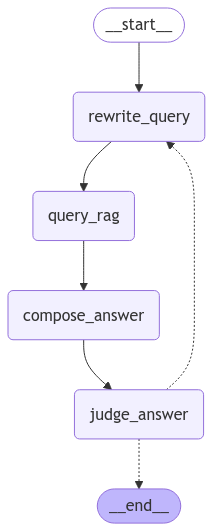

In [28]:
rewrite_prompt = ChatPromptTemplate(
    [
        (
            "system",
            """You are a helpful research assistant that rewrites queries to fit the research purpose.\n \
               The new query should based on the previous retrieval results and answers.\
               If it is first iteration, simply optimize the query.""",
        ),
        (
            "human",
            """Here is the initial question: {original_query}, \n \
               Here are the previous retrieval results: {retrieval_results}, \n \
               Here is the previous answer: {answer}, \n \
               Formulate an improved question:""",
        ),
    ]
)

answer_prompt = ChatPromptTemplate(
    [
        (
            "system",
            "You are a RAG agent. Use the retrieved context to answer the query comprehensively",
        ),
        (
            "human",
            """Here is the query: {current_query}\
                Here are the retrieval results: {retrieval_results}\
                Answer the query based on the retrieval results:""",
        ),
    ]
)

judge_prompt = ChatPromptTemplate(
    [
        (
            "system",
            """You are a grading assistant, \
                you judge whether the answer is satisfactory given the query asked.\
                if it's not satisfactory, you ask for a requery.\
                if it's satisfactory, you respond to user directly.
                The response should be in json format, including two fields: \
                   - "needs_requery": boolean, whether the answer needs to requery\
                   - "reason": string, the reason for the judgment\
                """,
        ),
        (
            "human",
            """Here is the query: {current_query}\
           Here is the answer: {answer}\
           Is the answer satisfactory?""",
        ),
    ]
)


# rewrite query to fit research purpose
def rewrite_query(state: RAGState) -> RAGState:
    """Rewrite the query to produce a better question"""
    msg = rewrite_prompt.invoke(
        {
            "original_query": state["original_query"],
            "retrieval_results": state["retrieval_results"],
            "answer": state["answer"],
        }
    )
    llm = ChatOpenAI(model="gpt-3.5-turbo")
    response = llm.invoke(msg)
    state["current_query"] = response.content
    return state


# query rag or respond
def query_rag(state: RAGState) -> RAGState:
    """Generate tool call for RAG or respond"""
    llm = ChatOpenAI(model="gpt-3.5-turbo")
    llm_with_tools = llm.bind_tools(
        tools=[retrieve_from_vectorstore],
        tool_choice="retrieve_from_vectorstore",
    )
    response = llm_with_tools.invoke(state["current_query"])
    state["messages"] = [response]
    return state


tool_node = ToolNode([retrieve_from_vectorstore])


# compose answer
def compose_answer(state: RAGState) -> RAGState:
    """Compose the final answer"""
    state["retrieval_results"] = state["messages"][-1].content
    llm = ChatOpenAI(model="gpt-3.5-turbo")
    msg = answer_prompt.invoke(
        {
            "current_query": state["current_query"],
            "retrieval_results": state["retrieval_results"],
        }
    )
    response = llm.invoke(msg)
    state["answer"] = response.content
    return state


# judge answer
def judge_answer(state: RAGState) -> RAGState:
    """Judge whether the answer is satisfactory"""
    llm = ChatOpenAI(model="gpt-3.5-turbo")
    msg = judge_prompt.invoke(
        {
            "current_query": state["current_query"],
            "answer": state["answer"],
        }
    )
    response = llm.invoke(msg)
    json_response = json.loads(response.content)
    print(json_response["reason"])
    if json_response["needs_requery"]:
        return {"next": "rewrite_query"}
    return {"next": "end"}


# define the function to determine to continue or end
def should_continue(state: MessagesState) -> Literal["rewrite_query", END]:
    """Determine whether to continue or end"""
    message = state["next"]
    if message == "rewrite_query":
        return "rewrite_query"
    return END


graph_builder = StateGraph(RAGState)
graph_builder.add_node(rewrite_query)
graph_builder.add_node(query_rag)
graph_builder.add_node(compose_answer)
graph_builder.add_node(judge_answer)

graph_builder.add_edge(START, "rewrite_query")
graph_builder.add_edge("rewrite_query", "query_rag")
graph_builder.add_edge("query_rag", "compose_answer")
graph_builder.add_edge("compose_answer", "judge_answer")
graph_builder.add_conditional_edges(
    "judge_answer",
    should_continue,
    {"rewrite_query": "rewrite_query", END: END},
)


graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
original_query = "What is PILCO?"

response = graph.invoke(
    {
        "original_query": original_query,
        "current_query": "",
        "retrieval_results": [],
        "answer": "",
    }
)

The answer is detailed and directly addresses the query about the Probabilistic Inference for Learning Control (PILCO) algorithm and how it works in optimizing control policies in reinforcement learning tasks.


In [30]:
print(response["answer"])

The Probabilistic Inference for Learning Control (PILCO) algorithm is a model-based reinforcement learning approach that aims to optimize control policies in an efficient and sample-efficient manner. PILCO combines probabilistic modeling with Gaussian processes to learn a dynamics model of the system and optimize control policies based on this learned model.

Here's how PILCO works in optimizing control policies in reinforcement learning tasks:

1. **Probabilistic Modeling**: PILCO uses Gaussian processes to model the dynamics of the system. Gaussian processes provide a flexible and probabilistic way to model the mapping between control inputs and system states. This probabilistic modeling allows PILCO to capture uncertainty in the system dynamics.

2. **Long-Term Prediction**: PILCO leverages its learned probabilistic dynamics model to make long-term predictions about the future behavior of the system under different control policies. By considering uncertainty in these predictions, P

## RAG + Judge + Google Search


In [31]:
class RAGState(TypedDict):
    messages: list[AnyMessage]  # adapt to MessagesState
    original_query: str
    current_query: str
    retrieval_results: list[str]
    answer: str

### Test without graph

In [32]:
# original_query = "Can help me find PILCO in Google Search"
original_query = "What is PILCO?"
state = RAGState(
    messages="",
    original_query=original_query,
    current_query="",
    retrieval_results=[],
    google_search_results="",
    answer="",
)

# rewrite query
msg = rewrite_prompt.invoke(
    {
        "original_query": state["original_query"],
        "retrieval_results": [],
        "answer": [],
    }
)
llm = ChatOpenAI(model="gpt-3.5-turbo")
response = llm.invoke(msg)
state["current_query"] = response.content

# call tool
llm = ChatOpenAI(model="gpt-3.5-turbo")
llm_with_tools = llm.bind_tools(
    [retrieve_from_vectorstore],
    tool_choice="retrieve_from_vectorstore",
)
response2 = llm_with_tools.invoke(state["current_query"])
state["messages"] = [response2]

# tool invoke
tool_node = ToolNode([retrieve_from_vectorstore])
response3 = tool_node.invoke(state)
state["retrieval_results"] = response3["messages"][-1].content

# compose answer
llm = ChatOpenAI(model="gpt-3.5-turbo")
msg = answer_prompt.invoke(
    {
        "current_query": state["current_query"],
        "retrieval_results": state["retrieval_results"],
    }
)
response4 = llm.invoke(msg)
state["answer"] = response4.content

In [33]:
google_tool_prompt = ChatPromptTemplate(
    [
        (
            "system",
            """
            You are a helpful assistant that can use tools to answer user's questions. \
            You can decide to use tool or not
            """,
        ),
        ("user", "{current_query}"),
    ]
)

In [34]:
# assume yes go google search
llm = ChatOpenAI(model="gpt-3.5-turbo")
llm_with_tools = llm.bind_tools(
    [google_search],
    tool_choice="auto",
)
msg = google_tool_prompt.invoke({"current_query": state["current_query"]})
response6 = llm_with_tools.invoke(msg)
state["messages"] = [response6]

In [35]:
response6.tool_calls

[{'name': 'google_search',
  'args': {'query': 'Probabilistic Inference for Learning Control (PILCO) algorithm'},
  'id': 'call_dJBJexuKB29vwOo7enKGOcPZ',
  'type': 'tool_call'}]

In [36]:
# tool invoke
tool_node = ToolNode([google_search])
response7 = tool_node.invoke(state)

In [37]:
response7["messages"][-1].content

'This is a re-implementation of the PILCO algorithm (originally written in MATLAB) in Python using Tensorflow and GPflow. Based on these ideas, we propose a model-based policy search method, which we call pilco (probabilistic inference for learning control). Pilco achieves ... This package implements a Model-based Reinforcement Learning algorithm called Monte Carlo Probabilistic Inference for Learning and COntrol (MC-PILCO), ... This package implements a Model-based Reinforcement Learning algorithm called Monte Carlo Probabilistic Inference for Learning and COntrol (MC-PILCO), In model-based methods of reinforcement learning (RL), the probabilistic inference for learning control (PILCO) algorithm, which relies on ... Based on these ideas, we propose a model-based policy search method, which we call pilco (probabilistic inference for learning control). Pilco achieves ... PILCO is one of the most important Model-Based Reinforcement Learning algorithms draws a lot of attention from resear

In [38]:
# compose answer together
google_search_answer_prompt = ChatPromptTemplate(
    [
        (
            "system",
            """
            You are a research assistant\
            refine the answer given the query and some research paper content and google search result.\
            the main content should be the research paper content, only add in google search content when necessary.\
            """,
        ),
        (
            "human",
            """
            This is the query: {current_query}\
            This is the research paper content: {answer}\
            This is the google search result: {google_search_results}\
            You should refine the answer:
            """,
        ),
    ]
)

llm = ChatOpenAI(model="gpt-3.5-turbo")
msg = google_search_answer_prompt.invoke(
    {
        "current_query": state["current_query"],
        "answer": state["answer"],
        "google_search_results": response7["messages"][-1].content,
    }
)
response8 = llm.invoke(msg)

In [39]:
print(response8.content)

The Probabilistic Inference for Learning Control (PILCO) algorithm is a model-based reinforcement learning method that incorporates uncertainty into the learning process. By utilizing uncertainty within the inner-loop of a policy search method, PILCO enables effective control learning with minimal data collected. This contrasts with traditional methods that rely on best-fit models, potentially compromising performance.

PILCO leverages explicit Monte-Carlo simulation in sample estimates and treats model uncertainty as noise. Through analytic approximations of forward simulation, tasks like solving a cart-pole task with minimal interaction with the physical system have been achieved efficiently. PILCO has also successfully solved linearized control problems with multiple probabilistic models, combining closed-loop and open-loop control strategies for tasks like autonomous sideways sliding into a parking spot.

The Google search results highlight a re-implementation of the PILCO algorith

In [40]:
# judge answer
llm = ChatOpenAI(model="gpt-4o-mini")
msg = judge_prompt.invoke(
    {
        "current_query": state["current_query"],
        "answer": response8.content,
    }
)
response5 = llm.invoke(msg)
json_response = json.loads(response5.content)

In [41]:
json_response

{'needs_requery': False,
 'reason': 'The answer provides a clear and detailed explanation of the PILCO algorithm, its function in reinforcement learning, its methodology, and relevant applications, making it satisfactory.'}

### Build the graph

In [42]:
class RAGState(TypedDict):
    messages: list[AnyMessage]  # adapt to MessagesState
    original_query: str
    current_query: str
    retrieval_results: list[str]
    answer: str

In [43]:
rewrite_prompt = ChatPromptTemplate(
    [
        (
            "system",
            """You are a helpful research assistant that rewrites queries to fit the research purpose.\n \
               The new query should based on the previous retrieval results and answers.\
               If it is first iteration, simply optimize the query.""",
        ),
        (
            "human",
            """Here is the initial question: {original_query}, \n \
               Here are the previous retrieval results: {retrieval_results}, \n \
               Here is the previous answer: {answer}, \n \
               Formulate an improved question:""",
        ),
    ]
)

answer_prompt = ChatPromptTemplate(
    [
        (
            "system",
            "You are a RAG agent. Use the retrieved context to answer the query comprehensively",
        ),
        (
            "human",
            """Here is the query: {current_query}\
                Here are the retrieval results: {retrieval_results}\
                Answer the query based on the retrieval results:""",
        ),
    ]
)

judge_prompt = ChatPromptTemplate(
    [
        (
            "system",
            """You are a grading assistant, \
                you judge whether the answer is satisfactory given the query asked.\
                if it's not satisfactory, you ask for a requery.\
                if it's satisfactory, you respond to user directly.
                The response should be in json format, including two fields: \
                   - "needs_requery": boolean, whether the answer needs to requery\
                   - "reason": string, the reason for the judgment\
                """,
        ),
        (
            "human",
            """Here is the query: {current_query}\
           Here is the answer: {answer}\
           Is the answer satisfactory?""",
        ),
    ]
)

google_tool_prompt = ChatPromptTemplate(
    [
        (
            "system",
            """
            You are a helpful assistant that can use tools to answer user's questions. \
            You can decide to use tool or not
            """,
        ),
        ("user", "{current_query}"),
    ]
)

google_search_answer_prompt = ChatPromptTemplate(
    [
        (
            "system",
            """
            You are a research assistant\
            refine the answer given the query and some research paper content and google search result.\
            the main content should be the research paper content, only add in google search content when necessary.\
            """,
        ),
        (
            "human",
            """
            This is the query: {current_query}\
            This is the research paper content: {answer}\
            This is the google search result: {google_search_results}\
            You should refine the answer:
            """,
        ),
    ]
)

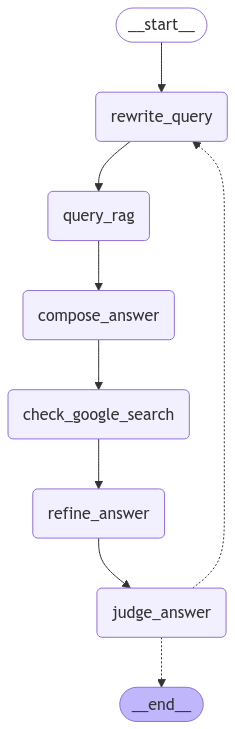

In [44]:
# rewrite query to fit research purpose
def rewrite_query(state: RAGState) -> RAGState:
    """Rewrite the query to produce a better question"""
    msg = rewrite_prompt.invoke(
        {
            "original_query": state["original_query"],
            "retrieval_results": state["retrieval_results"],
            "answer": state["answer"],
        }
    )
    llm = ChatOpenAI(model="gpt-3.5-turbo")
    response = llm.invoke(msg)
    state["current_query"] = response.content
    print(f"===== Rewrite Query =====")
    print(f"New Query: {state['current_query']}")
    return state


# query rag or respond
def query_rag(state: RAGState) -> RAGState:
    """Generate tool call for RAG or respond"""
    llm = ChatOpenAI(model="gpt-3.5-turbo")
    llm_with_tools = llm.bind_tools(
        tools=[retrieve_from_vectorstore],
        tool_choice="retrieve_from_vectorstore",
    )
    response = llm_with_tools.invoke(state["current_query"])
    state["messages"] = [response]
    print("===== Query RAG =====")
    print(f"tool call: {response.tool_calls}")
    return state


retrieve_tool = ToolNode([retrieve_from_vectorstore])


# compose answer
def compose_answer(state: RAGState) -> RAGState:
    """Compose the final answer"""
    state["retrieval_results"] = state["messages"][-1].content
    llm = ChatOpenAI(model="gpt-3.5-turbo")
    msg = answer_prompt.invoke(
        {
            "current_query": state["current_query"],
            "retrieval_results": state["retrieval_results"],
        }
    )
    response = llm.invoke(msg)
    state["answer"] = response.content
    print("===== Compose Answer =====")
    print(f"tool result: {state['retrieval_results']}")
    print(f"Compose Answer: {state['answer']}")
    return state


# check google search
def check_google_search(state: RAGState) -> RAGState:
    """Check if google search is needed"""
    llm = ChatOpenAI(model="gpt-3.5-turbo")
    llm_with_tools = llm.bind_tools(
        [google_search],
        tool_choice="auto",
    )
    msg = google_tool_prompt.invoke({"current_query": state["current_query"]})
    response = llm_with_tools.invoke(msg)
    state["messages"] = [response]
    print("===== Check Google Search =====")
    print(f"tool call: {response.tool_calls}")
    return state


google_tool = ToolNode([google_search])


# refine answer with google search
def refine_answer(state: RAGState) -> RAGState:
    """Refine the answer with google search"""
    state["google_search_results"] = state["messages"][-1].content
    llm = ChatOpenAI(model="gpt-3.5-turbo")
    msg = google_search_answer_prompt.invoke(
        {
            "current_query": state["current_query"],
            "answer": state["answer"],
            "google_search_results": state["google_search_results"],
        }
    )
    response = llm.invoke(msg)
    state["answer"] = response.content
    print("===== Refine Answer =====")
    print(f"tool result: {state['google_search_results']}")
    print(f"Refine Answer: {state['answer']}")
    return state


# judge answer
def judge_answer(state: RAGState) -> RAGState:
    """Judge whether the answer is satisfactory"""
    llm = ChatOpenAI(model="gpt-3.5-turbo")
    msg = judge_prompt.invoke(
        {
            "current_query": state["current_query"],
            "answer": state["answer"],
        }
    )
    response = llm.invoke(msg)
    json_response = json.loads(response.content)
    print("===== Judge Answer =====")
    print(json_response["reason"])
    if json_response["needs_requery"]:
        return {"next": "rewrite_query"}
    return {"next": "end"}


# define the function to determine to continue or end
def should_continue(state: MessagesState) -> Literal["rewrite_query", END]:
    """Determine whether to continue or end"""
    message = state["next"]
    if message == "rewrite_query":
        return "rewrite_query"
    return END


graph_builder = StateGraph(RAGState)
graph_builder.add_node(rewrite_query)
graph_builder.add_node(query_rag)
graph_builder.add_node(compose_answer)
graph_builder.add_node(check_google_search)
graph_builder.add_node(refine_answer)
graph_builder.add_node(judge_answer)

graph_builder.add_edge(START, "rewrite_query")
graph_builder.add_edge("rewrite_query", "query_rag")
graph_builder.add_edge("query_rag", "compose_answer")
graph_builder.add_edge("compose_answer", "check_google_search")
graph_builder.add_edge("check_google_search", "refine_answer")
graph_builder.add_edge("refine_answer", "judge_answer")
graph_builder.add_conditional_edges(
    "judge_answer",
    should_continue,
    {"rewrite_query": "rewrite_query", END: END},
)

graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
original_query = "What is PILCO?"

response = graph.invoke(
    {
        "original_query": original_query,
        "current_query": "",
        "retrieval_results": [],
        "answer": "",
    }
)

===== Rewrite Query =====
New Query: What is the Probabilistic Inference for Learning Control (PILCO) algorithm and how does it improve learning in robotics and control systems?
===== Query RAG =====
tool call: [{'name': 'retrieve_from_vectorstore', 'args': {'query': 'Probabilistic Inference for Learning Control (PILCO) algorithm'}, 'id': 'call_nsNmdOWmItQ5jZArToeHcx42', 'type': 'tool_call'}]
===== Compose Answer =====
tool result: 
Compose Answer: The Probabilistic Inference for Learning Control (PILCO) algorithm is a model-based reinforcement learning algorithm that aims to improve learning in robotics and control systems by combining probabilistic modeling with Gaussian processes. PILCO focuses on learning control policies directly in the space of raw sensory inputs, enabling the robot or control system to learn more efficiently and perform better in complex and uncertain environments.

PILCO improves learning in robotics and control systems in several ways:

1. **Model-Based Learni

In [46]:
print(response["answer"])

The Probabilistic Inference for Learning Control (PILCO) algorithm is a model-based reinforcement learning algorithm that utilizes probabilistic modeling with Gaussian processes to enhance learning in robotics and control systems. PILCO focuses on learning control policies directly from raw sensory inputs, which helps robots and control systems learn more efficiently and perform better in complex and uncertain environments.

PILCO improves learning in robotics and control systems through various mechanisms:

1. **Model-Based Learning**: By using a probabilistic model based on Gaussian processes, PILCO captures system dynamics' uncertainty, leading to more informed decision-making during learning.

2. **Uncertainty Estimation**: Through Gaussian processes, PILCO effectively handles system uncertainty and noise, enabling robust and adaptive control decisions.

3. **Sample Efficiency**: PILCO optimizes control policies to achieve a specific performance objective, such as minimizing energy

### Compare with simple ReAct

In [47]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

model = ChatOpenAI(model="gpt-3.5-turbo")
agent = create_react_agent(
    model=model,
    tools=[google_search, retrieve_from_vectorstore],
    checkpointer=MemorySaver(),
)


def ask_agent(query: str) -> str:
    input = {"messages": [HumanMessage(content=query)]}
    for s in agent.stream(
        input, stream_mode="values", config={"configurable": {"thread_id": "thread-1"}}
    ):
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [48]:
ask_agent("What is PILCO?")

================================ Human Message =================================

What is PILCO?
================================== Ai Message ==================================
Tool Calls:
  google_search (call_tVBajjjvi2j6ubDheqTm7hAM)
 Call ID: call_tVBajjjvi2j6ubDheqTm7hAM
  Args:
    query: PILCO
================================= Tool Message =================================
Name: google_search

Abstract. In this paper, we introduce pilco, a practi- cal, data-efficient model-based policy search method. Pilco reduces model bias, one of. In this paper, we introduce PILCO, a practical, data-efficient model-based policy search method. PILCO reduces model bias, one of the key problems of ... PILCO is one of the most important Model-Based Reinforcement Learning algorithms draws a lot of attention from researchers. Solving the toughest challenges for the energy and chemical industries · What We Do · Trusted advisors to C-suites, boards and deal teams for more than 40 years. In this sect

PILCO stands for Probabilistic Inference for Learning Control. It is a practical and data-efficient model-based policy search method used in reinforcement learning. PILCO reduces model bias, which is one of the key problems in reinforcement learning algorithms.

In [49]:
ask_agent("What is PILCO in vectorestore?")

================================ Human Message =================================

What is PILCO in vectorestore?
================================== Ai Message ==================================
Tool Calls:
  retrieve_from_vectorstore (call_UFJeDPHmTddR4PjxeTIzg3xo)
 Call ID: call_UFJeDPHmTddR4PjxeTIzg3xo
  Args:
    query: PILCO
================================= Tool Message =================================
Name: retrieve_from_vectorstore

Source: pdfs\Kober et al. - 2013 - Reinforcement learning in robotics A survey.pdf
Content: representation. Several of these controllers can be combined to form a global, inherently
closed-loop policy. This type of policy has allowed for many applications, including
learning helicopter ﬂight (Bagnell and Schneider, 2001), learning biped walk patterns
(Tedrake, 2004; Tedrake et al., 2005), driving a radio-controlled (RC) car, learning a
jumping behavior for a robot dog (Kolter and Ng, 2009a) (illustrated in Figure 5), and
balancing a two wheeled robo

In the context of the Vectorstore, the term "PILCO" is mentioned in a document related to reinforcement learning in robotics. It discusses the use of controllers to form closed-loop policies for various applications such as learning helicopter flight, biped walk patterns, driving a radio-controlled car, and balancing a two-wheeled robot. Additionally, it mentions the use of non-parametric policies based on regression approaches for a more data-driven learning process.

# Agentic RAG Chatbot

In [50]:
from langgraph.graph import MessagesState, StateGraph, END, START
from langgraph.prebuilt import ToolNode
from langchain.prompts import ChatPromptTemplate
from langchain.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_core.messages import AnyMessage, SystemMessage
from langchain_core.tools import tool
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.memory import MemorySaver

from typing import TypedDict, Literal, List
from pathlib import Path
import os

In [51]:
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")
if not os.environ.get("SERPER_API_KEY"):
    os.environ["SERPER_API_KEY"] = getpass.getpass("Enter API key for SERPER: ")

pdf_path = Path("pdfs")
pdf_files = [f for f in pdf_path.iterdir() if f.suffix == ".pdf"]

In [52]:
class RAGState(TypedDict):
    messages: list[AnyMessage]  # adapt to MessagesState
    original_query: str
    current_query: str
    retrieval_results: list[str]
    answer: str

In [53]:
rewrite_prompt = ChatPromptTemplate(
    [
        (
            "system",
            """You are a helpful research assistant that rewrites queries to fit the research purpose.\n \
               The new query should based on the previous retrieval results and answers.\
               If it is first iteration, simply optimize the query.""",
        ),
        (
            "human",
            """Here is the initial question: {original_query}, \n \
               Here are the previous retrieval results: {retrieval_results}, \n \
               Here is the previous answer: {answer}, \n \
               Formulate an improved question:""",
        ),
    ]
)

answer_prompt = ChatPromptTemplate(
    [
        (
            "system",
            "You are a RAG agent. Use the retrieved context to answer the query comprehensively",
        ),
        (
            "human",
            """Here is the query: {current_query}\
                Here are the retrieval results: {retrieval_results}\
                Answer the query based on the retrieval results:""",
        ),
    ]
)

judge_prompt = ChatPromptTemplate(
    [
        (
            "system",
            """You are a grading assistant, \
                you judge whether the answer is satisfactory given the query asked.\
                if it's not satisfactory, you ask for a requery.\
                if it's satisfactory, you respond to user directly.
                The response should be in json format, including two fields: \
                   - "needs_requery": boolean, whether the answer needs to requery\
                   - "reason": string, the reason for the judgment\
                """,
        ),
        (
            "human",
            """Here is the query: {current_query}\
           Here is the answer: {answer}\
           Is the answer satisfactory?""",
        ),
    ]
)

google_tool_prompt = ChatPromptTemplate(
    [
        (
            "system",
            """
            You are a helpful assistant that can use tools to answer user's questions. \
            You can decide to use tool or not
            """,
        ),
        ("user", "{current_query}"),
    ]
)

google_search_answer_prompt = ChatPromptTemplate(
    [
        (
            "system",
            """
            You are a research assistant\
            refine the answer given the query and some research paper content and google search result.\
            the main content should be the research paper content, only add in google search content when necessary.\
            """,
        ),
        (
            "human",
            """
            This is the query: {current_query}\
            This is the research paper content: {answer}\
            This is the google search result: {google_search_results}\
            You should refine the answer:
            """,
        ),
    ]
)


answer_prompt = ChatPromptTemplate(
    [
        (
            "system",
            "You are a RAG agent. Use the retrieved context to answer the query comprehensively",
        ),
        (
            "human",
            """Here is the query: {current_query}\
                Here are the retrieval results: {retrieval_results}\
                Answer the query based on the retrieval results:""",
        ),
    ]
)

judge_prompt = ChatPromptTemplate(
    [
        (
            "system",
            """You are a grading assistant, \
                you judge whether the answer is satisfactory given the query asked.\
                if it's not satisfactory, you ask for a requery.\
                if it's satisfactory, you respond to user directly.
                The response should be in json format, including two fields: \
                   - "needs_requery": boolean, whether the answer needs to requery\
                   - "reason": string, the reason for the judgment\
                """,
        ),
        (
            "human",
            """Here is the query: {current_query}\
           Here is the answer: {answer}\
           Is the answer satisfactory?""",
        ),
    ]
)

In [54]:
def load_graph(pdf_files):
    # load
    docs = []
    for pdf in pdf_files:
        loader = PyPDFLoader(str(pdf))
        docs.extend(loader.load())

    # split
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    splits = text_splitter.split_documents(docs)

    # embed
    embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

    # vector store
    persist_directory = Path("chroma_db")
    if not persist_directory.exists():
        persist_directory.mkdir()

    vector_store = Chroma.from_documents(
        splits, embeddings, persist_directory=str(persist_directory)
    )

    # tools
    
    @tool(response_format="content")
    def google_search(query: str) -> str:
        """Search Google for the given query."""
        search = GoogleSerperAPIWrapper()
        return search.run(query)

    @tool(response_format="content_and_artifact")
    def retrieve_from_vectorstore(query: str):
        """Retrieve documents from the vectorstore."""
        retrieved_docs = vector_store.similarity_search(query, k=3)
        serialized = "\n\n".join(
            (f"Source: {doc.metadata['source']}\n" f"Content: {doc.page_content}")
            for doc in retrieved_docs
        )
        return serialized, retrieved_docs
        
    # rewrite query to fit research purpose
    def rewrite_query(state: RAGState) -> RAGState:
        """Rewrite the query to produce a better question"""
        msg = rewrite_prompt.invoke(
            {
                "original_query": state["original_query"],
                "retrieval_results": state["retrieval_results"],
                "answer": state["answer"],
            }
        )
        llm = ChatOpenAI(model="gpt-3.5-turbo")
        response = llm.invoke(msg)
        state["current_query"] = response.content
        print(f"===== Rewrite Query =====")
        print(f"New Query: {state['current_query']}")
        return state

    # query rag or respond
    def query_rag(state: RAGState) -> RAGState:
        """Generate tool call for RAG or respond"""
        llm = ChatOpenAI(model="gpt-3.5-turbo")
        llm_with_tools = llm.bind_tools(
            tools=[retrieve_from_vectorstore],
            tool_choice="retrieve_from_vectorstore",
        )
        response = llm_with_tools.invoke(state["current_query"])
        state["messages"] = [response]
        print("===== Query RAG =====")
        print(f"tool call: {response.tool_calls}")
        return state

    retrieve_tool = ToolNode([retrieve_from_vectorstore])

    # compose answer
    def compose_answer(state: RAGState) -> RAGState:
        """Compose the final answer"""
        state["retrieval_results"] = state["messages"][-1].content
        llm = ChatOpenAI(model="gpt-3.5-turbo")
        msg = answer_prompt.invoke(
            {
                "current_query": state["current_query"],
                "retrieval_results": state["retrieval_results"],
            }
        )
        response = llm.invoke(msg)
        state["answer"] = response.content
        print("===== Compose Answer =====")
        print(f"tool result: {state['retrieval_results']}")
        print(f"Compose Answer: {state['answer']}")
        return state

    # check google search
    def check_google_search(state: RAGState) -> RAGState:
        """Check if google search is needed"""
        llm = ChatOpenAI(model="gpt-3.5-turbo")
        llm_with_tools = llm.bind_tools(
            [google_search],
            tool_choice="auto",
        )
        msg = google_tool_prompt.invoke({"current_query": state["current_query"]})
        response = llm_with_tools.invoke(msg)
        state["messages"] = [response]
        print("===== Check Google Search =====")
        print(f"tool call: {response.tool_calls}")
        return state

    google_tool = ToolNode([google_search])

    # refine answer with google search
    def refine_answer(state: RAGState) -> RAGState:
        """Refine the answer with google search"""
        state["google_search_results"] = state["messages"][-1].content
        llm = ChatOpenAI(model="gpt-3.5-turbo")
        msg = google_search_answer_prompt.invoke(
            {
                "current_query": state["current_query"],
                "answer": state["answer"],
                "google_search_results": state["google_search_results"],
            }
        )
        response = llm.invoke(msg)
        state["answer"] = response.content
        print("===== Refine Answer =====")
        print(f"tool result: {state['google_search_results']}")
        print(f"Refine Answer: {state['answer']}")
        return state

    # judge answer
    def judge_answer(state: RAGState) -> RAGState:
        """Judge whether the answer is satisfactory"""
        llm = ChatOpenAI(model="gpt-3.5-turbo")
        msg = judge_prompt.invoke(
            {
                "current_query": state["current_query"],
                "answer": state["answer"],
            }
        )
        response = llm.invoke(msg)
        json_response = json.loads(response.content)
        print("===== Judge Answer =====")
        print(json_response["reason"])
        if json_response["needs_requery"]:
            return {"next": "rewrite_query"}
        return {"next": "end"}

    # define the function to determine to continue or end
    def should_continue(state: MessagesState) -> Literal["rewrite_query", END]:
        """Determine whether to continue or end"""
        message = state["next"]
        if message == "rewrite_query":
            return "rewrite_query"
        return END

    # build langgraph
    graph_builder = StateGraph(RAGState)
    graph_builder.add_node(rewrite_query)
    graph_builder.add_node(query_rag)
    graph_builder.add_node(compose_answer)
    graph_builder.add_node(check_google_search)
    graph_builder.add_node(refine_answer)
    graph_builder.add_node(judge_answer)

    graph_builder.add_edge(START, "rewrite_query")
    graph_builder.add_edge("rewrite_query", "query_rag")
    graph_builder.add_edge("query_rag", "compose_answer")
    graph_builder.add_edge("compose_answer", "check_google_search")
    graph_builder.add_edge("check_google_search", "refine_answer")
    graph_builder.add_edge("refine_answer", "judge_answer")
    graph_builder.add_conditional_edges(
        "judge_answer",
        should_continue,
        {"rewrite_query": "rewrite_query", END: END},
    )

    memory = MemorySaver()
    graph = graph_builder.compile(checkpointer=memory)
    return graph

In [55]:
import panel as pn

pn.extension()
import param


class cbfs(param.Parameterized):
    chat_history = param.List([])
    answer = param.String("")
    db_query = param.String("")
    db_response = param.List([])

    def __init__(self, **params):
        super(cbfs, self).__init__(**params)
        self.panels = []
        self.chat_history = []
        self.pdf_path = Path("pdfs")
        self.pdf_files = [f for f in pdf_path.iterdir() if f.suffix == ".pdf"]
        self.qa = load_graph(self.pdf_files)

    def convchain(self, query):
        if not query:
            return
        inp.value = ""
        config = {"configurable": {"thread_id": "1"}}
        result = self.qa.invoke({"original_query": query,
                                "current_query":"",
                                "retrieval_results": [],
                                "answer": "",}, config=config,)
        self.answer = result["answer"]
        self.chat_history.extend([(query, self.answer)])
        self.panels.extend(
            [
                pn.Row("User:", pn.pane.Markdown(query, width=450)),
                pn.Row(
                    "ChatBot:",
                    pn.pane.Markdown(
                        self.answer, width=450, styles={"background-color": "#F6F6F6"}
                    ),
                ),
            ]
        )
        return pn.WidgetBox(*self.panels, scroll=True)

    @param.depends("convchain", "clr_history")
    def get_chats(self):
        if not self.chat_history:
            return pn.WidgetBox(
                pn.Row(pn.pane.Str("No History Yet")), width=600, scroll=True
            )
        rlist = [
            pn.Row(
                pn.pane.Markdown(
                    f"Current Chat History variable",
                    styles={"background-color": "#F6F6F6"},
                )
            )
        ]
        for exchange in self.chat_history:
            rlist.append(pn.Row(pn.pane.Str(exchange)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    def clr_history(self, count=0):
        self.chat_history = []
        return

In [57]:
cb = cbfs()

button_clearhistory = pn.widgets.Button(name="Clear History", button_type="warning")
button_clearhistory.on_click(cb.clr_history)
inp = pn.widgets.TextInput(placeholder="Enter text here…")

conversation = pn.bind(cb.convchain, inp)

tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation, loading_indicator=True, height=400),
    pn.layout.Divider(),
)

tab3 = pn.Column(
    pn.panel(cb.get_chats),
    pn.layout.Divider(),
)

dashboard = pn.Column(
    pn.Row(pn.pane.Markdown("# ChatWithYourData_Bot")),
    pn.Tabs(("Conversation", tab1), ("Chat History", tab3)),
)
dashboard

Ignoring wrong pointing object 501 0 (offset 0)
Ignoring wrong pointing object 503 0 (offset 0)
Ignoring wrong pointing object 529 0 (offset 0)
Ignoring wrong pointing object 572 0 (offset 0)
Ignoring wrong pointing object 577 0 (offset 0)
Ignoring wrong pointing object 945 0 (offset 0)
Ignoring wrong pointing object 949 0 (offset 0)


Column
    [0] Row
        [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Row
                [0] TextInput(placeholder='Enter text here…')
            [1] Divider()
            [2] ParamFunction(function, _pane=Str, defer_load=False, height=400, loading_indicator=True)
            [3] Divider()
        [1] Column
            [0] ParamMethod(method, _pane=WidgetBox, defer_load=False)
            [1] Divider()